# 基于U型语义分割模型实现的宠物图像分割

本示例教程当前是基于2.0-beta版本Paddle做的案例实现，未来会随着2.0的系列版本发布进行升级。

## 1.简要介绍

在计算机视觉领域，图像分割指的是将数字图像细分为多个图像子区域的过程。图像分割的目的是简化或改变图像的表示形式，使得图像更容易理解和分析。图像分割通常用于定位图像中的物体和边界（线，曲线等）。更精确的，图像分割是对图像中的每个像素加标签的一个过程，这一过程使得具有相同标签的像素具有某种共同视觉特性。图像分割的领域非常多，无人车、地块检测、表计识别等等。

本示例简要介绍如何通过飞桨开源框架，实现图像分割。这里我们是采用了一个在图像分割领域比较熟知的U-Net网络结构，是一个基于FCN做改进后的一个深度学习网络，包含下采样（编码器，特征提取）和上采样（解码器，分辨率还原）两个阶段，因模型结构比较像U型而命名为U-Net。

## 2.环境设置

导入一些比较基础常用的模块，确认自己的飞桨版本。

In [2]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PilImage

import paddle
from paddle.nn import functional as F

paddle.__version__

'0.0.0'

## 3.数据集

### 3.1 数据集下载

本案例使用Oxford-IIIT Pet数据集，官网：https://www.robots.ox.ac.uk/~vgg/data/pets 。

数据集统计如下：

![alt 数据集统计信息](https://www.robots.ox.ac.uk/~vgg/data/pets/breed_count.jpg)

数据集包含两个压缩文件：

1. 原图：https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
2. 分割图像：https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [2]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  2428k      0  0:05:18  0:05:18 --:--:-- 5592k  0  2071k      0  0:06:13  0:00:23  0:05:50 2304k    0     0  2239k      0  0:05:45  0:00:53  0:04:52 3108k0  2607k      0  0:04:56  0:01:05  0:03:51 4402k 0  0:04:33  0:01:15  0:03:18 4383k29  220M    0     0  2746k      0  0:04:41  0:01:22  0:03:19 1733k1:28  0:03:22 1395k476k      0  0:05:12  0:01:37  0:03:35 1507k 2320k      0  0:05:33  0:01:55  0:03:38 1297k2323k      0  0:05:32  0:01:58  0:03:34 2045k17  0:02:10  0:03:07 4157k  0  0:05:24  0:02:35  0:02:49 1542k 2381k      0  0:05:24  0:02:37  0:02:47 2077k   0  0:05:34  0:02:55  0:02:39 2520k5:34  0:02:56  0:02:38 2462k    0     0  2368k      0  0:05:26  0:03:24  0:02:02 2582k2444k      0  0:05:16  0:03:41  0:01:35 2174k:04:09  0:01:23 1638k13k      0  0:05:34  0:04:25  0:01:09 2396k2 3048k5M    

### 3.2 数据集概览

首先我们先看看下载到磁盘上的文件结构是什么样，来了解一下我们的数据集。

1. 首先看一下images.tar.gz这个压缩包，该文件解压后得到一个images目录，这个目录比较简单，里面直接放的是用类名和序号命名好的图片文件，每个图片是对应的宠物照片。

```bash
.
├── samoyed_7.jpg
├── ......
└── samoyed_81.jpg
```

2. 然后我们在看下annotations.tar.gz，文件解压后的目录里面包含以下内容，目录中的README文件将每个目录和文件做了比较详细的介绍，我们可以通过README来查看每个目录文件的说明。

```bash
.
├── README
├── list.txt
├── test.txt
├── trainval.txt
├── trimaps
│    ├── Abyssinian_1.png
│    ├── Abyssinian_10.png
│    ├── ......
│    └── yorkshire_terrier_99.png
└── xmls
      ├── Abyssinian_1.xml
      ├── Abyssinian_10.xml
      ├── ......
      └── yorkshire_terrier_190.xml
```

本次我们主要使用到images和annotations/trimaps两个目录，即原图和三元图像文件，前者作为训练的输入数据，后者是对应的标签数据。

我们来看看这个数据集给我们提供了多少个训练样本。

In [3]:
train_images_path = "images/"
label_images_path = "annotations/trimaps/"

print("用于训练的图片样本数量:", len([os.path.join(train_images_path, image_name) 
          for image_name in os.listdir(train_images_path) 
          if image_name.endswith('.jpg')]))

用于训练的图片样本数量: 7390


### 3.3 数据集类定义

飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先我们先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，`__getitem__`和`__len__`：

```python
class MyDataset(Dataset):
    def __init__(self):
        ...
        
    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return x, y

    # 返回整个数据集的总数
    def __len__(self):
        return count(samples)
```

在数据集内部可以结合图像数据预处理相关API进行图像的预处理（改变大小、反转、调整格式等）。

由于加载进来的图像不一定都符合自己的需求，举个例子，已下载的这些图片里面就会有RGBA格式的图片，这个时候图片就不符合我们所需3通道的需求，我们需要进行图片的格式转换，那么这里我们直接实现了一个通用的图片读取接口，确保读取出来的图片都是满足我们的需求。

另外图片加载出来的默认shape是HWC，这个时候要看看是否满足后面训练的需要，如果Layer的默认格式和这个不是符合的情况下，需要看下Layer有没有参数可以进行格式调整。不过如果layer较多的话，还是直接调整原数据Shape比较好，否则每个layer都要做参数设置，如果有遗漏就会导致训练出错，那么在本案例中是直接对数据源的shape做了统一调整，从HWC转换成了CHW，因为飞桨的卷积等API的默认输入格式为CHW，这样处理方便后续模型训练。

In [4]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms


class ImgTranspose(object):
    """
    图像预处理工具，用于将Mask图像进行升维(160, 160) => (160, 160, 1)，
    并对图像的维度进行转换从HWC变为CHW
    """
    def __init__(self, fmt):
        self.format = fmt
        
    def __call__(self, img):
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
            
        return img.transpose(self.format)

class PetDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, image_path, label_path, mode='train'):
        """
        构造函数
        """
        self.image_size = (160, 160)
        self.image_path = image_path
        self.label_path = label_path
        self.mode = mode.lower()
        self.eval_image_num = 1000
        
        assert self.mode in ['train', 'test'], \
            "mode should be 'train' or 'test', but got {}".format(self.mode)
        
        self._parse_dataset()
        
        self.transforms = transforms.Compose([
            ImgTranspose((2, 0, 1))
        ])
        
    def _sort_images(self, image_dir, image_type):
        """
        对文件夹内的图像进行按照文件名排序
        """
        files = []

        for image_name in os.listdir(image_dir):
            if image_name.endswith('.{}'.format(image_type)) \
                    and not image_name.startswith('.'):
                files.append(os.path.join(image_dir, image_name))

        return sorted(files)
        
    def _parse_dataset(self):
        """
        由于所有文件都是散落在文件夹中，在训练时我们需要使用的是数据集和标签对应的数据关系，
        所以我们第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。
        这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。
        在这里是用了一个非常简单的方法，按照文件名称进行排序。
        因为刚好数据和标签的文件名是按照这个逻辑制作的，名字都一样，只有扩展名不一样。
        """
        temp_train_images = self._sort_images(self.image_path, 'jpg')
        temp_label_images = self._sort_images(self.label_path, 'png')

        random.Random(1337).shuffle(temp_train_images)
        random.Random(1337).shuffle(temp_label_images)
        
        if self.mode == 'train':
            self.train_images = temp_train_images[:-self.eval_image_num]
            self.label_images = temp_label_images[:-self.eval_image_num]
        else:
            self.train_images = temp_train_images[-self.eval_image_num:]
            self.label_images = temp_label_images[-self.eval_image_num:]
    
    def _load_img(self, path, color_mode='rgb'):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')

            if self.image_size is not None:
                if img.size != self.image_size:
                    img = img.resize(self.image_size, PilImage.NEAREST)

            return img

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        # 花了比较多的时间在数据处理这里，需要处理成模型能适配的格式，踩了一些坑（比如有不是RGB格式的）
        # 有图片会出现通道数和期望不符的情况，需要进行相关考虑

        # 加载原始图像
        train_image = self._load_img(self.train_images[idx])
        x = np.array(train_image, dtype='float32')

        # 对图像进行预处理，统一大小，转换维度格式（HWC => CHW）
        x = self.transforms(x)
        
        # 加载Label图像
        label_image = self._load_img(self.label_images[idx], color_mode="grayscale")  
        y = np.array(label_image, dtype='uint8')  

        # 图像预处理
        # Label图像是二维的数组(size, size)，升维到(size, size, 1)后才能用于最后loss计算
        y = self.transforms(y)
        
        # 返回img, label，转换为需要的格式
        return x, y.astype('int64')
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

### 3.4 PetDataSet数据集抽样展示

实现好Dataset数据集后，我们来测试一下数据集是否符合预期，因为Dataset是一个可以被迭代的Class，我们通过for循环从里面读取数据来用matplotlib进行展示，这里要注意的是对于分割的标签文件因为是1通道的灰度图片，需要在使用imshow接口时注意下传参cmap='gray'。

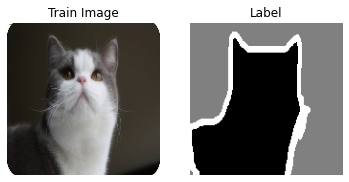

In [5]:
# 训练数据集
train_dataset = PetDataset(train_images_path, label_images_path, mode='train')

# 验证数据集
val_dataset = PetDataset(train_images_path, label_images_path, mode='test')

# 抽样一个数据
image, label = train_dataset[0]

# 进行图片的展示
plt.figure()

plt.subplot(1,2,1), 
plt.title('Train Image')
plt.imshow(image.transpose((1, 2, 0)).astype('uint8'))
plt.axis('off')

plt.subplot(1,2,2), 
plt.title('Label')
plt.imshow(np.squeeze(label, axis=0).astype('uint8'), cmap='gray')
plt.axis('off')

plt.show()

## 4.模型组网

U-Net是一个U型网络结构，可以看做两个大的阶段，图像先经过Encoder编码器进行下采样得到高级语义特征图，再经过Decoder解码器上采样将特征图恢复到原图片的分辨率。

### 4.1 自定义模型可视化工具类


@TODO，summary接口正在PR中，等Merge后替换为summary接口调用。


In [6]:
from tabulate import tabulate

class ModelTools(object):
    def __init__(self):
        self.debug_table_data = []
        self.param_total_count = 0
        
    def _get_param_info(self, layer):
        total_count = 0
        
        for param in layer.parameters():
            item_size = 1

            for axis_len in param.shape:
                item_size *= axis_len

            total_count += item_size

        return total_count

    def write_log(self, layer, in_shape, out_shape):
        if type(layer) is not str:
            layer_name = layer.full_name()
            param_count = self._get_param_info(layer)
        else:
            layer_name = layer
            param_count = 0
        
        self.param_total_count += param_count
        self.debug_table_data.append([layer_name, in_shape, out_shape, param_count])

    def invoke(self, layer, inputs, inputs_2=None, layer_name=None):
        if inputs_2 is not None:
            in_shape = '{} + {}'.format(inputs.shape, inputs_2.shape)
            output = layer(inputs, inputs_2)
        else:
            in_shape = inputs.shape
            output = layer(inputs)

        layer_name = layer_name if layer_name is not None else layer
        self.write_log(layer_name, in_shape, output.shape)

        return output
    
    def show(self):
        print(tabulate(self.debug_table_data, headers=['Layer', 'In Shape', 'Out Shape', 'Param Num'], tablefmt='pretty'))
        print('Total Params: {}'.format(self.param_total_count))

### 4.2 定义SeparableConv2d接口

我们为了减少卷积操作中的训练参数来提升性能，是继承paddle.nn.Layer自定义了一个SeparableConv2d Layer类，整个过程是把`filter_size * filter_size * num_filters`的Conv2d操作拆解为两个子Conv2d，先对输入数据的每个通道使用`filter_size * filter_size * 1`的卷积核进行计算，输入输出通道数目相同，之后在使用`1 * 1 * num_filters`的卷积核计算。

In [7]:
class SeparableConv2d(paddle.nn.Layer):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride=1, 
                 padding=0, 
                 dilation=1, 
                 groups=None, 
                 weight_attr=None, 
                 bias_attr=None, 
                 data_format="NCHW"):
        super(SeparableConv2d, self).__init__()
        # 第一次卷积操作没有偏置参数
        self.conv_1 = paddle.nn.Conv2d(in_channels, 
                                       in_channels, 
                                       kernel_size, 
                                       stride=stride,
                                       padding=padding,
                                       dilation=dilation,
                                       groups=in_channels, 
                                       weight_attr=weight_attr, 
                                       bias_attr=False,  
                                       data_format=data_format)
        self.pointwise = paddle.nn.Conv2d(in_channels, 
                                          out_channels, 
                                          1, 
                                          stride=1, 
                                          padding=0, 
                                          dilation=1, 
                                          groups=1, 
                                          weight_attr=weight_attr, 
                                          data_format=data_format)
        
    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.pointwise(x)

        return x

### 4.3 定义Encoder编码器

我们将网络结构中的Encoder下采样过程进行了一个Layer封装，方便后续调用，减少代码编写，下采样是有一个模型逐渐向下画曲线的一个过程，这个过程中是不断的重复一个单元结构将通道数不断增加，形状不断缩小，并且引入残差网络结构，我们将这些都抽象出来进行统一封装。

In [8]:
class Encoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, tools):
        super(Encoder, self).__init__()
        self.tools = tools
        
        self.relu = paddle.nn.ReLU()
        self.separable_conv_01 = SeparableConv2d(in_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.bn = paddle.nn.BatchNorm2d(out_channels)
        self.separable_conv_02 = SeparableConv2d(out_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.pool = paddle.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_conv = paddle.nn.Conv2d(in_channels, 
                                              out_channels, 
                                              kernel_size=1, 
                                              stride=2, 
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        x = self.tools.invoke(self.relu, inputs)
        x = self.tools.invoke(self.separable_conv_01, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.relu, x)
        x = self.tools.invoke(self.separable_conv_02, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.pool, x)
        residual = self.tools.invoke(self.residual_conv, previous_block_activation)
        x = self.tools.invoke(paddle.add, x, inputs_2=residual, layer_name='ADD')

        return x

### 4.4 定义Decoder解码器

在通道数达到最大得到高级语义特征图后，网络结构会开始进行decode操作，进行上采样，通道数逐渐减小，对应图片尺寸逐步增加，直至恢复到原图像大小，那么这个过程里面也是通过不断的重复相同结构的残差网络完成，我们也是为了减少代码编写，将这个过程定义一个Layer来放到模型组网中使用。

In [9]:
class Decoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, tools):
        super(Decoder, self).__init__()
        self.tools = tools

        self.relu = paddle.nn.ReLU()
        self.conv_transpose_01 = paddle.nn.ConvTranspose2d(in_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding='same')
        self.conv_transpose_02 = paddle.nn.ConvTranspose2d(out_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding='same')
        self.bn = paddle.nn.BatchNorm2d(out_channels)
        self.upsample = paddle.nn.UpSample(scale_factor=2.0)
        self.residual_conv = paddle.nn.Conv2d(in_channels, 
                                              out_channels, 
                                              kernel_size=1, 
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        x = self.tools.invoke(self.relu, inputs)
        x = self.tools.invoke(self.conv_transpose_01, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.relu, x)
        x = self.tools.invoke(self.conv_transpose_02, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.upsample, x)
        residual = self.tools.invoke(self.upsample, previous_block_activation)
        residual = self.tools.invoke(self.residual_conv, residual)
        x = self.tools.invoke(paddle.add, x, inputs_2=residual, layer_name='ADD')
        
        return x

### 4.5 训练模型组网

按照U型网络结构格式进行整体的网络结构搭建，三次下采样，四次上采样。

In [10]:
class PetModel(paddle.nn.Layer):
    def __init__(self, num_classes, tools):
        super(PetModel, self).__init__()
        self.tools = tools

        self.conv_1 = paddle.nn.Conv2d(3, 32, 
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2d(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        # 根据下采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_%s'.format(out_channels),
                                      Encoder(in_channels, out_channels, self.tools))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        # 根据上采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_%s'.format(out_channels), 
                                      Decoder(in_channels, out_channels, self.tools))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2d(in_channels, 
                                            num_classes, 
                                            kernel_size=3, 
                                            padding='same')
    
    def forward(self, inputs):
        y = self.tools.invoke(self.conv_1, inputs)
        y = self.tools.invoke(self.bn, y)
        y = self.tools.invoke(self.relu, y)
        
        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)
        
        y = self.tools.invoke(self.output_conv, y)
        
        return y

### 4.6 模型可视化

调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。
@TODO，需要替换

In [11]:
paddle.disable_static()

num_classes = 4
model_tools = ModelTools()
model = PetModel(num_classes, model_tools)

data = paddle.to_tensor(np.expand_dims(train_dataset[0][0].astype('float32'), 0))
res = model(data)

model_tools.show()

+--------------------+---------------------------------------+-------------------+-----------+
|       Layer        |               In Shape                |     Out Shape     | Param Num |
+--------------------+---------------------------------------+-------------------+-----------+
|      conv2d_0      |           [1, 3, 160, 160]            |  [1, 32, 80, 80]  |    896    |
|   batch_norm2d_0   |            [1, 32, 80, 80]            |  [1, 32, 80, 80]  |    128    |
|      re_lu_0       |            [1, 32, 80, 80]            |  [1, 32, 80, 80]  |     0     |
|      re_lu_1       |            [1, 32, 80, 80]            |  [1, 32, 80, 80]  |     0     |
| separable_conv2d_0 |            [1, 32, 80, 80]            |  [1, 64, 80, 80]  |   2400    |
|   batch_norm2d_1   |            [1, 64, 80, 80]            |  [1, 64, 80, 80]  |    256    |
|      re_lu_1       |            [1, 64, 80, 80]            |  [1, 64, 80, 80]  |     0     |
| separable_conv2d_1 |            [1, 64, 80, 80] 

## 5.模型训练

### 5.1 配置信息

定义训练BATCH_SIZE、训练轮次和计算设备等信息。

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15
device = paddle.set_device('gpu')
paddle.disable_static(device)

### 5.3 自定义Loss

在这个任务中我们使用SoftmaxWithCrossEntropy损失函数来做计算，飞桨中有functional形式的API，这里我们做一个自定义操作，实现一个Class形式API放到模型训练中使用。没有直接使用CrossEntropyLoss的原因主要是对计算维度的自定义需求，本次需要进行softmax计算的维度是1，不是默认的最后一维，所以我们采用上面提到的损失函数，通过axis参数来指定softmax计算维度。

In [13]:
class SoftmaxWithCrossEntropy(paddle.nn.Layer):
    def __init__(self):
        super(SoftmaxWithCrossEntropy, self).__init__()

    def forward(self, input, label):
        loss = F.softmax_with_cross_entropy(input, 
                                            label, 
                                            return_softmax=False,
                                            axis=1)
        return paddle.mean(loss)

### 5.4 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [ ]:
optim = paddle.optimizer.RMSProp(learning_rate=0.001, 
                                 rho=0.9, 
                                 momentum=0.0, 
                                 epsilon=1e-07, 
                                 centered=False,
                                 parameters=model.parameters())
model = paddle.Model(PetModel(num_classes, model_tools))
model.prepare(optim, 
              SoftmaxWithCrossEntropy())

model.fit(train_dataset, 
    val_dataset, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

## 6.模型预测

### 6.1 预测数据集准备和预测

继续使用PetDataset来实例化待预测使用的数据集。这里我们为了方便没有在另外准备预测数据，复用了评估数据。

我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [ ]:
predict_results = model.predict(val_dataset)

### 6.2 预测结果可视化

从我们的预测数据集中抽3个动物来看看预测的效果，展示一下原图、标签图和预测结果。

In [ ]:
plt.figure(figsize=(10, 10))

i = 0
mask_idx = 0

for data in val_dataset:
    if i > 8: 
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(data[0].transpose((1, 2, 0)).astype('uint8'))
    plt.title('Input Image')
    plt.axis("off")

    plt.subplot(3, 3, i + 2)
    plt.imshow(np.squeeze(data[1], axis=0).astype('uint8'), cmap='gray')
    plt.title('Label')
    plt.axis("off")
    
    
    data = val_preds[0][mask_idx][0].transpose((1, 2, 0))
    mask = np.argmax(data, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    plt.subplot(3, 3, i + 3)
    plt.imshow(np.squeeze(mask, axis=2).astype('uint8'), cmap='gray')
    plt.title('Predict')
    plt.axis("off")
    i += 3
    mask_idx += 1

plt.show()